In [108]:
!apt-get install -y ffmpeg
!pip install pydub librosa
!pip install noisereduce
!pip install soundfile

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [109]:
# Libraries

# Audio Processing Libraries
import librosa  # For audio file handling and feature extraction
import numpy as np  # For numerical operations
from pydub import AudioSegment  # For handling audio file formats
from noisereduce import reduce_noise  # For noise reduction

# PyTorch Libraries
import torch  # For creating and manipulating tensors
import torch.nn as nn  # For defining neural network layers
import torch.nn.functional as F  # For activation functions and operations
import torch.optim as optim  # For optimizers like Adam
from torch.utils.data import DataLoader, TensorDataset  # For data handling and batching
from torch.optim.lr_scheduler import StepLR  # For adjusting the learning rate after a certain number of epochs
from torchvision import models, transforms


# Scikit-learn for Data Handling
from sklearn.model_selection import train_test_split  # For splitting datasets into training and testing sets

# OS for file handling
import os  # For interacting with the operating system

# Google Colab Drive for accessing files
from google.colab import drive

In [110]:
import warnings

# Suppress specific warnings from librosa
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")
warnings.filterwarnings("ignore", category=FutureWarning, module="librosa")
warnings.filterwarnings("ignore", category=UserWarning, message=".*PySoundFile failed.*")

In [111]:
# Mount Google Drive for dataset access
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/DL_project_dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
folder_path_predefined = '/content/drive/MyDrive/DL_project_predefined_dataset'

In [113]:
# Function to convert audio file to MFCC features
def audio_to_mfcc(file_path, sr=16000, n_mfcc=30, duration=4, offset=0):
    # Load audio file
    y, _ = librosa.load(file_path, sr=sr, duration=duration, offset=offset)
    # Trim silence at the beginning and end
    y_trimmed, _ = librosa.effects.trim(y, top_db=50)
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Normalize the MFCC features
    return (mfccs - np.mean(mfccs)) / np.std(mfccs)

In [114]:
# Function to prepare gender dataset for training
def prepare_data_gender(dataset_path, file_type=".m4a"):
    features = []  # List to store features
    labels = []  # List to store labels

    # Iterate through files in the dataset folder
    for file_name in os.listdir(dataset_path):
        if file_name.endswith(file_type):  # Only process .m4a files
            file_path = os.path.join(dataset_path, file_name)

            # Extract gender from the filename
            if 'f' in file_name.lower():  # Female label
                gender_label = 1
            elif 'm' in file_name.lower():  # Male label
                gender_label = 0
            else:
                continue  # Skip files without gender indication

            # Extract MFCC features from the audio file
            mel_spectrogram = audio_to_mfcc(file_path)

            # Append features and labels
            features.append(mel_spectrogram)
            labels.append(gender_label)

    return np.array(features), np.array(labels)  # Return features and labels as numpy arrays

In [115]:
# Function to prepare identity dataset for training
def prepare_data_identity(dataset_path, file_type=".m4a"):
    features, labels = [], []  # Lists to store features and labels
    for file_name in os.listdir(dataset_path):
        if file_name.endswith(file_type):  # Only process .m4a files
            file_path = os.path.join(dataset_path, file_name)
            parts = file_name.lower().split('_')
            identity_label = int(parts[0]) - 1  # Identity is the first part of the filename

            # Extract MFCC features from the audio file
            mel_spectrogram = audio_to_mfcc(file_path)

            # Append features and labels
            features.append(mel_spectrogram)
            labels.append(identity_label)

    return np.array(features), np.array(labels)  # Return features and labels as numpy arrays

In [116]:
# Function to preprocess data for PyTorch training
def preprocess_data(X, y, task, batch_size=8, num_classes=2, model_type="other"):
    y = torch.tensor(y, dtype=torch.long)  # Convert labels to PyTorch tensor

    if task == "gender":
        # 60% train, 20% validation, 20% test
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    elif task == "identity":
        # 4/6 train, 1/6 validation, 1/6 test
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=2/6, random_state=42, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


    if model_type == "lstm":
        # Convert features to PyTorch tensors (no reshaping needed for LSTM)
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    else:
        # Reshape features for CNN (samples, channels, height, width)
        X_train = X_train[..., np.newaxis]
        X_val = X_val[..., np.newaxis]
        X_test = X_test[..., np.newaxis]

        # Convert features to PyTorch tensors and adjust dimensions
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

    # Create PyTorch DataLoaders for training, validation, and testing
    train_dataset = TensorDataset(X_train_tensor, y_train)
    val_dataset = TensorDataset(X_val_tensor, y_val)
    test_dataset = TensorDataset(X_test_tensor, y_test)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader, testloader


In [117]:
# Function to calculate the number of time frames for the spectrogram
def get_time_frames(duration, sr=16000, hop_length=512):
    return int(np.ceil((duration * sr) / hop_length)) + 1  # Calculate number of time frames

**CNN**

In [118]:
class CNN(nn.Module):
    def __init__(self, num_classes, n_mels=30, duration=4, sr=16000):
        super(CNN, self).__init__()

        time_frames = get_time_frames(duration, sr)

        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output: (32, n_mels, time_frames)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization after conv1
        self.pool1 = nn.MaxPool2d(2, 2)  # Output: (32, n_mels/2, time_frames/2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: (64, n_mels/2, time_frames/2)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after conv2
        self.pool2 = nn.MaxPool2d(2, 2)  # Output: (64, n_mels/4, time_frames/4)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * (n_mels // 4) * (time_frames // 4), 128)  # Flattened dimensions after pooling
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)  # Flatten the features
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

**LSTM**

In [119]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Pass through the LSTM
        lstm_out, _ = self.lstm(x)
        # Take the last time step's output
        final_output = lstm_out[:, -1, :]
        # Pass through the fully connected layer
        out = self.fc(final_output)
        return out

**ResNet18**

In [120]:
from torchvision.models import resnet18

# Transform single-channel input to 3-channel input
class SingleToThreeChannelTransform:
    def __call__(self, x):
        if x.dim() == 2:  # If input is (H, W), add a channel dimension
            x = x.unsqueeze(0)  # Add channel dimension to make it (1, H, W)
        return x.repeat(3, 1, 1)  # Repeat to create 3 channels

# Function to modify ResNet18 for a custom number of output classes
def modify_resnet18(num_classes):
    model = resnet18(pretrained=True)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model

**EfficientNet-B0**

In [121]:
from torchvision.models import efficientnet_b0

# Transform single-channel input to 3-channel input
class SingleToThreeChannelTransform:
    def __call__(self, x):
        if x.dim() == 2:  # If input is (H, W), add a channel dimension
            x = x.unsqueeze(0)  # Add channel dimension to make it (1, H, W)
        return x.repeat(3, 1, 1)  # Repeat to create 3 channels

# Function to modify EfficientNet-B0 for a custom number of output classes
def modify_efficientnet_b0(num_classes):
    model = efficientnet_b0(pretrained=True)  # Load pre-trained EfficientNet-B0
    model.features[0][0] = nn.Conv2d(1, model.features[0][0].out_channels, kernel_size=3, stride=2, padding=1, bias=False)  # Modify to accept single-channel input
    num_ftrs = model.classifier[1].in_features  # Get the number of input features to the final fully connected layer
    model.classifier = nn.Sequential(
        nn.Dropout(0.6),  # Add dropout to reduce overfitting
        nn.Linear(num_ftrs, num_classes)  # Adjust for the number of output classes
    )
    return model


**Training and Evaluation**

In [122]:
import matplotlib.pyplot as plt

def plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plot training and validation loss and accuracy graphs.

    Parameters:
    - train_losses: List of training losses for each epoch.
    - val_losses: List of validation losses for each epoch.
    - train_accuracies: List of training accuracies for each epoch.
    - val_accuracies: List of validation accuracies for each epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='darkblue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='purple')
    plt.xticks(range(1, len(epochs) + 1, 5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='red')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.xticks(range(1, len(epochs) + 1, 5))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [123]:
# Training function for the model
def train(model, trainloader, criterion, optimizer, scheduler, valloader, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in trainloader:
            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        scheduler.step()  # Adjust learning rate

        # Evaluate on the validation set
        print(f"Epoch {epoch + 1}/{num_epochs} Validation Accuracy:")
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for val_inputs, val_labels in valloader:
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs, 1)
                total += val_labels.size(0)
                correct += (val_predicted == val_labels).sum().item()

        val_loss /= len(valloader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Early stopping condition based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Evaluation function to test the model
def evaluate(net, testloader):
    net.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():  # Disable gradient calculation
        for data in testloader:
            images, labels = data
            outputs = net(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total  # Calculate accuracy
    print(f'Accuracy on validation/test data: {accuracy:.2f}%')
    return accuracy

# Train and evaluate the model
def train_and_evaluate(trainloader, valloader, testloader, net, model_name, num_epochs=50):
    # Loss function, optimizer, and scheduler
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.01)  # AdamW optimizer with weight decay
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Learning rate scheduler

    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train(net, trainloader, criterion, optimizer, scheduler, valloader, num_epochs)

    # Save the trained model
    torch.save(net.state_dict(), f'{model_name}_best_model.pth')

    # Evaluate the model on the test set
    print("Evaluating on the test set:")
    evaluate(net, testloader)

    # Plot training and validation metrics
    plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Gender Prediction

Epoch 1/10 Validation Accuracy:
Validation Loss: 0.2220, Validation Accuracy: 95.00%
Epoch 2/10 Validation Accuracy:
Validation Loss: 0.0903, Validation Accuracy: 96.67%
Epoch 3/10 Validation Accuracy:
Validation Loss: 0.0593, Validation Accuracy: 100.00%
Epoch 4/10 Validation Accuracy:
Validation Loss: 0.0151, Validation Accuracy: 100.00%
Epoch 5/10 Validation Accuracy:
Validation Loss: 0.0065, Validation Accuracy: 100.00%
Epoch 6/10 Validation Accuracy:
Validation Loss: 0.0046, Validation Accuracy: 100.00%
Epoch 7/10 Validation Accuracy:
Validation Loss: 0.0036, Validation Accuracy: 100.00%
Epoch 8/10 Validation Accuracy:
Validation Loss: 0.0029, Validation Accuracy: 100.00%
Epoch 9/10 Validation Accuracy:
Validation Loss: 0.0024, Validation Accuracy: 100.00%
Epoch 10/10 Validation Accuracy:
Validation Loss: 0.0021, Validation Accuracy: 100.00%
Evaluating on the test set:
Accuracy on validation/test data: 96.67%


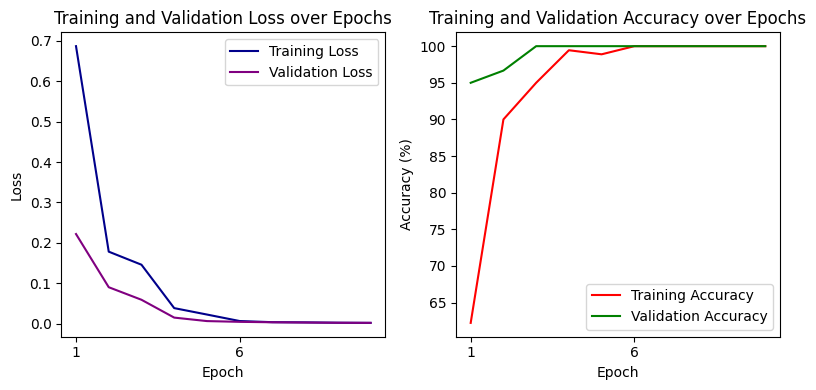

In [124]:
# Gender Prediction using CNN

X_gender, y_gender = prepare_data_gender(folder_path)

# Preprocess data to include train, validation, and test splits
trainloader_g, valloader_g, testloader_g = preprocess_data(X_gender, y_gender, task="gender")

net_cnn_gender = CNN(2)

# Train and evaluate the model, specifying a model name for saving
train_and_evaluate(trainloader_g, valloader_g, testloader_g, net_cnn_gender, model_name="cnn_gender", num_epochs=10)


Epoch 1/50 Validation Accuracy:
Validation Loss: 0.4897, Validation Accuracy: 75.00%
Epoch 2/50 Validation Accuracy:
Validation Loss: 0.2686, Validation Accuracy: 88.33%
Epoch 3/50 Validation Accuracy:
Validation Loss: 0.1847, Validation Accuracy: 93.33%
Epoch 4/50 Validation Accuracy:
Validation Loss: 0.1407, Validation Accuracy: 95.00%
Epoch 5/50 Validation Accuracy:
Validation Loss: 0.1330, Validation Accuracy: 95.00%
Epoch 6/50 Validation Accuracy:
Validation Loss: 0.1288, Validation Accuracy: 96.67%
Epoch 7/50 Validation Accuracy:
Validation Loss: 0.1428, Validation Accuracy: 96.67%
Epoch 8/50 Validation Accuracy:
Validation Loss: 0.1364, Validation Accuracy: 95.00%
Epoch 9/50 Validation Accuracy:
Validation Loss: 0.2303, Validation Accuracy: 93.33%
Early stopping at epoch 9
Evaluating on the test set:
Accuracy on validation/test data: 95.00%


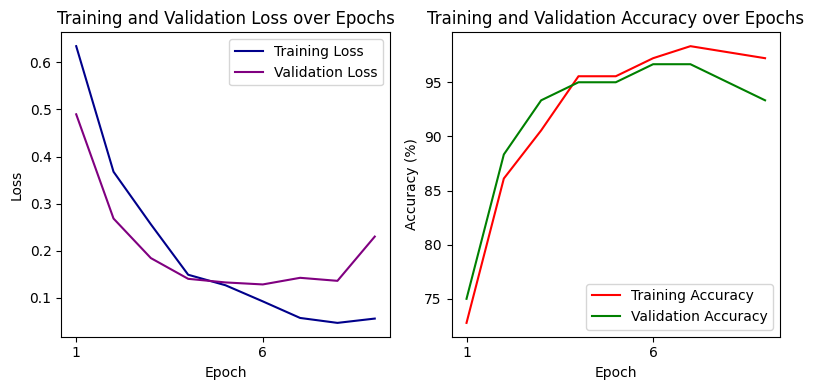

In [125]:
# Gender Prediction using LSTM

# Preprocess data to include train, validation, and test splits
trainloader_lstm_gender, valloader_lstm_gender, testloader_lstm_gender = preprocess_data(X_gender, y_gender, model_type="lstm", task="gender")

net_lstm_gender = LSTM(input_size=X_gender.shape[2], hidden_size=64, num_layers=2, num_classes=2)

# Train and evaluate the model, specifying a model name for saving
train_and_evaluate(trainloader_lstm_gender, valloader_lstm_gender, testloader_lstm_gender, net_lstm_gender, model_name="lstm_gender", num_epochs=50)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 Validation Accuracy:
Validation Loss: 0.1872, Validation Accuracy: 90.00%
Epoch 2/30 Validation Accuracy:
Validation Loss: 0.0672, Validation Accuracy: 96.67%
Epoch 3/30 Validation Accuracy:
Validation Loss: 0.1403, Validation Accuracy: 98.33%
Epoch 4/30 Validation Accuracy:
Validation Loss: 0.0325, Validation Accuracy: 98.33%
Epoch 5/30 Validation Accuracy:
Validation Loss: 0.0835, Validation Accuracy: 96.67%
Epoch 6/30 Validation Accuracy:
Validation Loss: 0.0634, Validation Accuracy: 100.00%
Epoch 7/30 Validation Accuracy:
Validation Loss: 0.0375, Validation Accuracy: 100.00%
Early stopping at epoch 7
Evaluating on the test set:
Accuracy on validation/test data: 96.67%


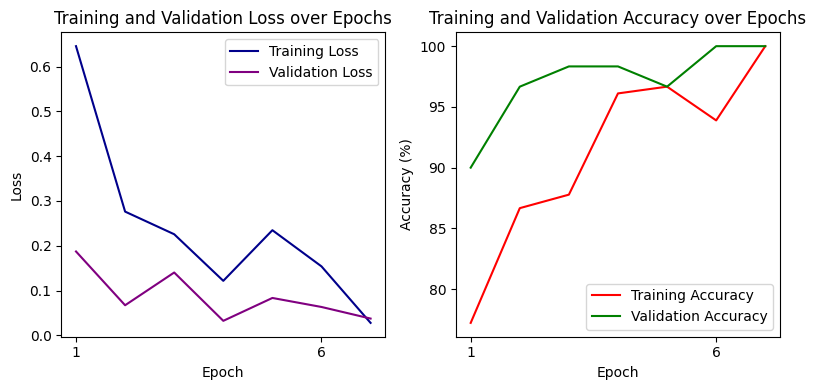

In [126]:
# Gender Prediction using ResNet18

# Prepare gender dataset
# X_gender, y_gender = prepare_data_gender(folder_path)

# Preprocess data to include train, validation, and test splits
trainloader_gender, valloader_gender, testloader_gender = preprocess_data(X_gender, y_gender, task="gender")

# Initialize ResNet18 model with the correct number of classes
num_classes_gender = 2
model_gender = modify_resnet18(num_classes_gender)

# Train and evaluate the ResNet18 model for gender prediction
train_and_evaluate(trainloader_gender, valloader_gender, testloader_gender, model_gender, model_name="resnet18_gender", num_epochs=30)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 Validation Accuracy:
Validation Loss: 1.1844, Validation Accuracy: 43.33%
Epoch 2/30 Validation Accuracy:
Validation Loss: 0.3315, Validation Accuracy: 90.00%
Epoch 3/30 Validation Accuracy:
Validation Loss: 0.1001, Validation Accuracy: 100.00%
Epoch 4/30 Validation Accuracy:
Validation Loss: 0.1252, Validation Accuracy: 96.67%
Epoch 5/30 Validation Accuracy:
Validation Loss: 0.0988, Validation Accuracy: 93.33%
Epoch 6/30 Validation Accuracy:
Validation Loss: 0.0574, Validation Accuracy: 100.00%
Epoch 7/30 Validation Accuracy:
Validation Loss: 0.0450, Validation Accuracy: 100.00%
Epoch 8/30 Validation Accuracy:
Validation Loss: 0.0354, Validation Accuracy: 100.00%
Epoch 9/30 Validation Accuracy:
Validation Loss: 0.0390, Validation Accuracy: 100.00%
Epoch 10/30 Validation Accuracy:
Validation Loss: 0.0301, Validation Accuracy: 100.00%
Epoch 11/30 Validation Accuracy:
Validation Loss: 0.0427, Validation Accuracy: 100.00%
Epoch 12/30 Validation Accuracy:
Validation Loss: 0.0425

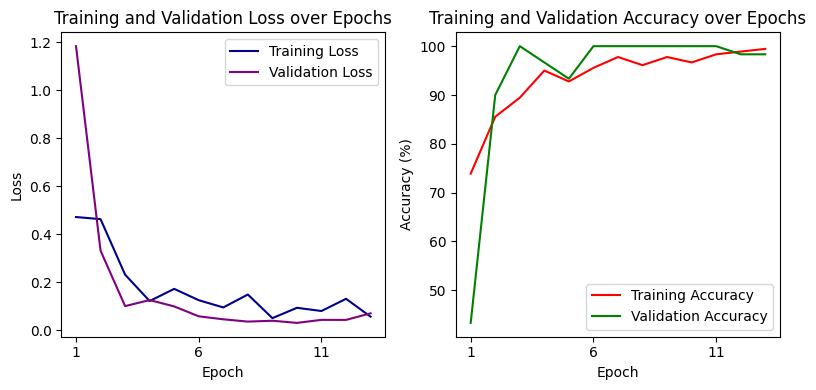

In [127]:
# Gender Prediction using EfficientNet-B0

# Prepare gender dataset
# X_gender, y_gender = prepare_data_gender(folder_path)

# Preprocess data to include train, validation, and test splits
trainloader_gender, valloader_gender, testloader_gender = preprocess_data(X_gender, y_gender, task="gender")

# Initialize EfficientNet-B0 model with the correct number of classes
num_classes_gender = 2
model_gender = modify_efficientnet_b0(num_classes_gender)

# Train and evaluate the EfficientNet-B0 model for gender prediction
train_and_evaluate(trainloader_gender, valloader_gender, testloader_gender, model_gender, model_name="efficientnet_b0_gender", num_epochs=30)


Identity Prediction

Epoch 1/30 Validation Accuracy:
Validation Loss: 3.9038, Validation Accuracy: 2.00%
Epoch 2/30 Validation Accuracy:
Validation Loss: 3.8990, Validation Accuracy: 4.00%
Epoch 3/30 Validation Accuracy:
Validation Loss: 3.6122, Validation Accuracy: 14.00%
Epoch 4/30 Validation Accuracy:
Validation Loss: 2.9808, Validation Accuracy: 26.00%
Epoch 5/30 Validation Accuracy:
Validation Loss: 2.6732, Validation Accuracy: 22.00%
Epoch 6/30 Validation Accuracy:
Validation Loss: 1.9328, Validation Accuracy: 46.00%
Epoch 7/30 Validation Accuracy:
Validation Loss: 2.0431, Validation Accuracy: 38.00%
Epoch 8/30 Validation Accuracy:
Validation Loss: 1.6295, Validation Accuracy: 44.00%
Epoch 9/30 Validation Accuracy:
Validation Loss: 1.4746, Validation Accuracy: 54.00%
Epoch 10/30 Validation Accuracy:
Validation Loss: 1.3680, Validation Accuracy: 58.00%
Epoch 11/30 Validation Accuracy:
Validation Loss: 1.3046, Validation Accuracy: 56.00%
Epoch 12/30 Validation Accuracy:
Validation Loss: 1.2237, Validat

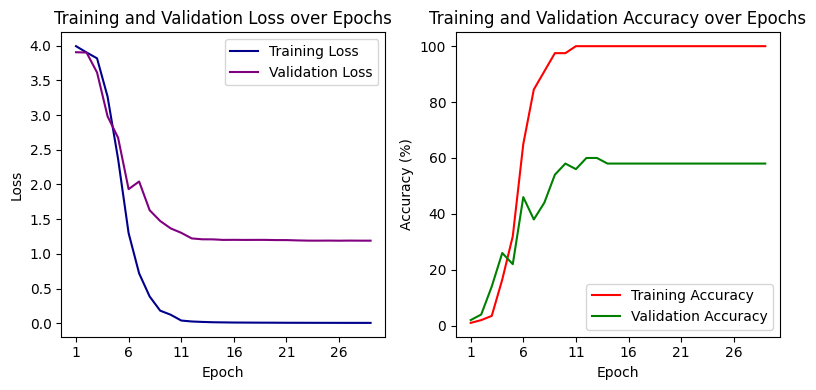

In [128]:
# Identity Prediction using CNN

X_identity, y_identity = prepare_data_identity(folder_path)

# Preprocess data to include train, validation, and test splits
trainloader_identity, valloader_identity, testloader_identity = preprocess_data(X_identity, y_identity, task="identity", num_classes=50)

net_identity = CNN(50)

# Train and evaluate the model, specifying a model name for saving
train_and_evaluate(trainloader_identity, valloader_identity, testloader_identity, net_identity, model_name="cnn_identity", num_epochs=30)


Epoch 1/50 Validation Accuracy:
Validation Loss: 3.7718, Validation Accuracy: 4.00%
Epoch 2/50 Validation Accuracy:
Validation Loss: 3.3807, Validation Accuracy: 16.00%
Epoch 3/50 Validation Accuracy:
Validation Loss: 2.9184, Validation Accuracy: 16.00%
Epoch 4/50 Validation Accuracy:
Validation Loss: 2.6140, Validation Accuracy: 26.00%
Epoch 5/50 Validation Accuracy:
Validation Loss: 2.4435, Validation Accuracy: 26.00%
Epoch 6/50 Validation Accuracy:
Validation Loss: 2.1083, Validation Accuracy: 38.00%
Epoch 7/50 Validation Accuracy:
Validation Loss: 1.9471, Validation Accuracy: 54.00%
Epoch 8/50 Validation Accuracy:
Validation Loss: 1.6859, Validation Accuracy: 58.00%
Epoch 9/50 Validation Accuracy:
Validation Loss: 1.6464, Validation Accuracy: 48.00%
Epoch 10/50 Validation Accuracy:
Validation Loss: 1.6152, Validation Accuracy: 52.00%
Epoch 11/50 Validation Accuracy:
Validation Loss: 1.4433, Validation Accuracy: 58.00%
Epoch 12/50 Validation Accuracy:
Validation Loss: 1.3859, Valida

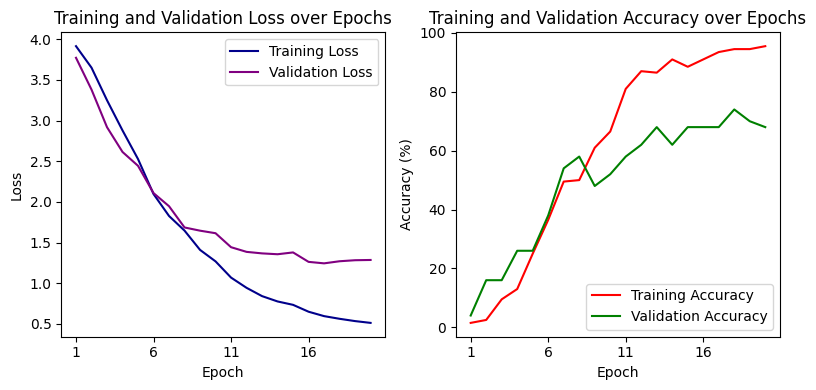

In [144]:
# Identity Prediction using LSTM

# Preprocess data to include train, validation, and test splits
trainloader_lstm_identity, valloader_lstm_identity, testloader_lstm_identity = preprocess_data(X_identity, y_identity, task="identity", model_type="lstm", num_classes=50)

net_lstm_identity = LSTM(input_size=X_identity.shape[2], hidden_size=256, num_layers=2, num_classes=50)

# Train and evaluate the model, specifying a model name for saving
train_and_evaluate(trainloader_lstm_identity, valloader_lstm_identity, testloader_lstm_identity, net_lstm_identity, model_name="lstm_identity", num_epochs=50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 Validation Accuracy:
Validation Loss: 25.9012, Validation Accuracy: 2.00%
Epoch 2/50 Validation Accuracy:
Validation Loss: 2.8297, Validation Accuracy: 28.00%
Epoch 3/50 Validation Accuracy:
Validation Loss: 2.4772, Validation Accuracy: 34.00%
Epoch 4/50 Validation Accuracy:
Validation Loss: 2.7637, Validation Accuracy: 30.00%
Epoch 5/50 Validation Accuracy:
Validation Loss: 3.4887, Validation Accuracy: 26.00%
Epoch 6/50 Validation Accuracy:
Validation Loss: 2.1782, Validation Accuracy: 48.00%
Epoch 7/50 Validation Accuracy:
Validation Loss: 1.3802, Validation Accuracy: 72.00%
Epoch 8/50 Validation Accuracy:
Validation Loss: 1.4325, Validation Accuracy: 70.00%
Epoch 9/50 Validation Accuracy:
Validation Loss: 0.9261, Validation Accuracy: 76.00%
Epoch 10/50 Validation Accuracy:
Validation Loss: 1.3697, Validation Accuracy: 62.00%
Epoch 11/50 Validation Accuracy:
Validation Loss: 0.6672, Validation Accuracy: 84.00%
Epoch 12/50 Validation Accuracy:
Validation Loss: 0.7109, Valid

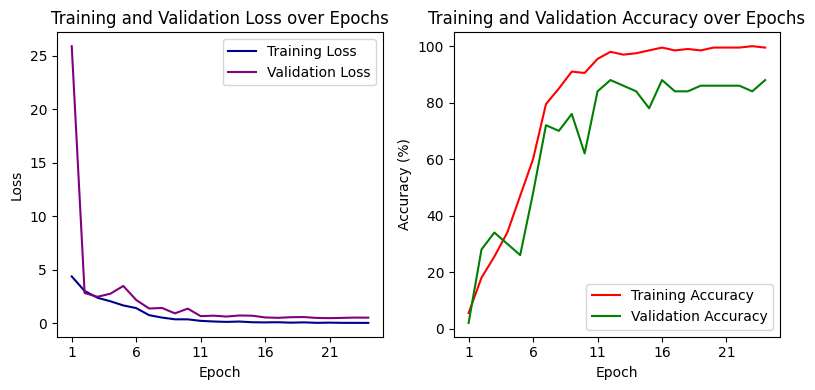

In [130]:
# Identity Prediction using ResNet18

# Prepare identity dataset
# X_identity, y_identity = prepare_data_identity(folder_path)

# Preprocess data to include train, validation, and test splits
trainloader_identity, valloader_identity, testloader_identity = preprocess_data(X_identity, y_identity, task="identity")

# Initialize ResNet18 model with the correct number of classes
num_classes_identity = 50
model_identity = modify_resnet18(num_classes_identity)

# Train and evaluate the ResNet18 model for identity prediction
train_and_evaluate(trainloader_identity, valloader_identity, testloader_identity, model_identity, model_name="resnet18_identity", num_epochs=50)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 Validation Accuracy:
Validation Loss: 3.9076, Validation Accuracy: 6.00%
Epoch 2/50 Validation Accuracy:
Validation Loss: 3.3471, Validation Accuracy: 14.00%
Epoch 3/50 Validation Accuracy:
Validation Loss: 2.6015, Validation Accuracy: 34.00%
Epoch 4/50 Validation Accuracy:
Validation Loss: 2.1540, Validation Accuracy: 46.00%
Epoch 5/50 Validation Accuracy:
Validation Loss: 1.8918, Validation Accuracy: 50.00%
Epoch 6/50 Validation Accuracy:
Validation Loss: 1.4005, Validation Accuracy: 68.00%
Epoch 7/50 Validation Accuracy:
Validation Loss: 1.1523, Validation Accuracy: 76.00%
Epoch 8/50 Validation Accuracy:
Validation Loss: 1.2078, Validation Accuracy: 70.00%
Epoch 9/50 Validation Accuracy:
Validation Loss: 1.0723, Validation Accuracy: 74.00%
Epoch 10/50 Validation Accuracy:
Validation Loss: 0.8712, Validation Accuracy: 78.00%
Epoch 11/50 Validation Accuracy:
Validation Loss: 0.9115, Validation Accuracy: 76.00%
Epoch 12/50 Validation Accuracy:
Validation Loss: 0.8992, Valida

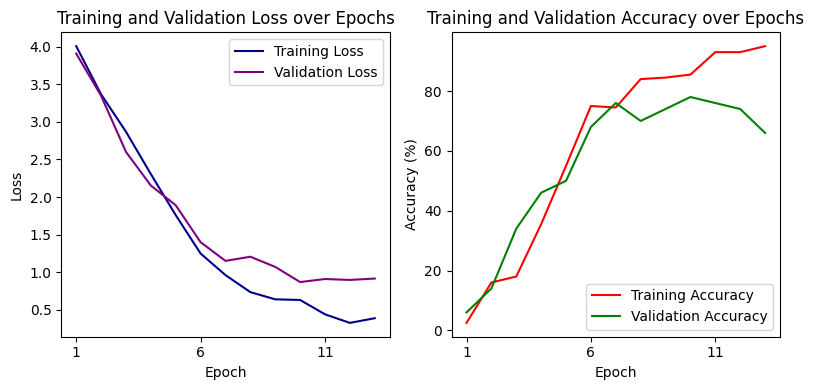

In [131]:
# Identity Prediction using EfficientNet-B0

# Prepare identity dataset
# X_identity, y_identity = prepare_data_identity(folder_path)

# Preprocess data to include train, validation, and test splits
trainloader_identity, valloader_identity, testloader_identity = preprocess_data(X_identity, y_identity, task="identity")

# Initialize EfficientNet-B0 model with the correct number of classes
num_classes_identity = 50
model_identity = modify_efficientnet_b0(num_classes_identity)

# Train and evaluate the EfficientNet-B0 model for identity prediction
train_and_evaluate(trainloader_identity, valloader_identity, testloader_identity, model_identity, model_name="efficientnet_b0_identity", num_epochs=50)


**Model Training and Evaluation Using Predefined Dataset**

In [132]:
from pydub import AudioSegment
import os

def convert_wav_to_flac(input_directory, output_directory):
    # Ensure output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Process each .wav file in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith(".wav"):
            wav_file_path = os.path.join(input_directory, filename)
            flac_file_path = os.path.join(output_directory, os.path.splitext(filename)[0] + ".flac")

            try:
                # Load the .wav file
                audio = AudioSegment.from_wav(wav_file_path)
                # Export as .flac
                audio.export(flac_file_path, format="flac")
                print(f"Converted: {filename} -> {os.path.basename(flac_file_path)}")
            except Exception as e:
                print(f"Failed to convert {filename}: {e}")

input_dir = "/content/drive/MyDrive/DL_project_predefined_dataset"
output_dir = "/content/drive/MyDrive/DL_project_predefined_dataset"
convert_wav_to_flac(input_dir, output_dir)


Converted: 41_1_m.wav -> 41_1_m.flac
Converted: 41_2_m.wav -> 41_2_m.flac
Converted: 41_3_m.wav -> 41_3_m.flac
Converted: 41_4_m.wav -> 41_4_m.flac
Converted: 41_5_m.wav -> 41_5_m.flac
Converted: 41_6_m.wav -> 41_6_m.flac
Converted: 42_1_f.wav -> 42_1_f.flac
Converted: 42_2_f.wav -> 42_2_f.flac
Converted: 42_3_f.wav -> 42_3_f.flac
Converted: 42_4_f.wav -> 42_4_f.flac
Converted: 42_5_f.wav -> 42_5_f.flac
Converted: 42_6_f.wav -> 42_6_f.flac
Converted: 43_1_m.wav -> 43_1_m.flac
Converted: 43_3_m.wav -> 43_3_m.flac
Converted: 43_2_m.wav -> 43_2_m.flac
Converted: 43_4_m.wav -> 43_4_m.flac
Converted: 43_5_m.wav -> 43_5_m.flac
Converted: 43_6_m.wav -> 43_6_m.flac
Converted: 44_1_f.wav -> 44_1_f.flac
Converted: 44_2_f.wav -> 44_2_f.flac
Converted: 44_3_f.wav -> 44_3_f.flac
Converted: 44_4_f.wav -> 44_4_f.flac
Converted: 44_5_f.wav -> 44_5_f.flac
Converted: 44_6_f.wav -> 44_6_f.flac
Converted: 45_1_m.wav -> 45_1_m.flac
Converted: 45_2_m.wav -> 45_2_m.flac
Converted: 45_3_m.wav -> 45_3_m.flac
C

Gender Prediction

Epoch 1/50 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 2/50 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 3/50 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 4/50 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Early stopping at epoch 4
Evaluating on the test set:
Accuracy on validation/test data: 100.00%


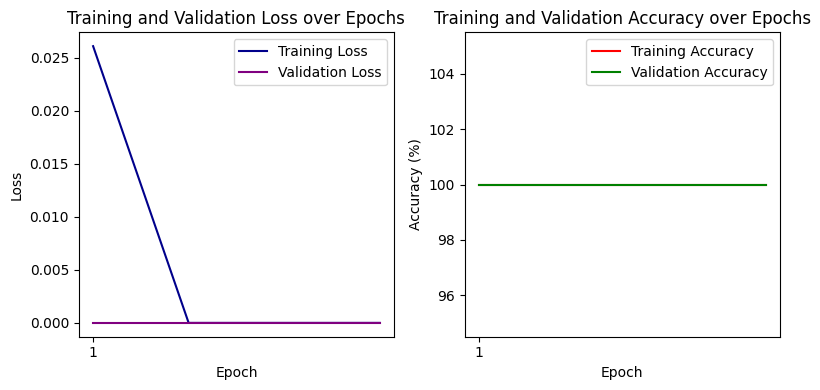

In [133]:
# Gender Prediction using CNN

X_gender_pre , y_gender_pre = prepare_data_gender(folder_path_predefined, ".flac")

# Preprocess data to include train, validation, and test splits
trainloader_g_pre, valloader_g_pre, testloader_g_pre = preprocess_data(X_gender_pre, y_gender_pre, task="gender")

net_cnn_gender = CNN(2)

# Train and evaluate the model, specifying a model name for saving
train_and_evaluate(trainloader_g_pre, valloader_g_pre, testloader_g_pre, net_cnn_gender, model_name="cnn_gender_pre", num_epochs=50)

Epoch 1/50 Validation Accuracy:
Validation Loss: 0.1905, Validation Accuracy: 95.00%
Epoch 2/50 Validation Accuracy:
Validation Loss: 0.1335, Validation Accuracy: 96.67%
Epoch 3/50 Validation Accuracy:
Validation Loss: 0.1122, Validation Accuracy: 96.67%
Epoch 4/50 Validation Accuracy:
Validation Loss: 0.1528, Validation Accuracy: 96.67%
Epoch 5/50 Validation Accuracy:
Validation Loss: 0.1330, Validation Accuracy: 96.67%
Epoch 6/50 Validation Accuracy:
Validation Loss: 0.1399, Validation Accuracy: 96.67%
Early stopping at epoch 6
Evaluating on the test set:
Accuracy on validation/test data: 96.67%


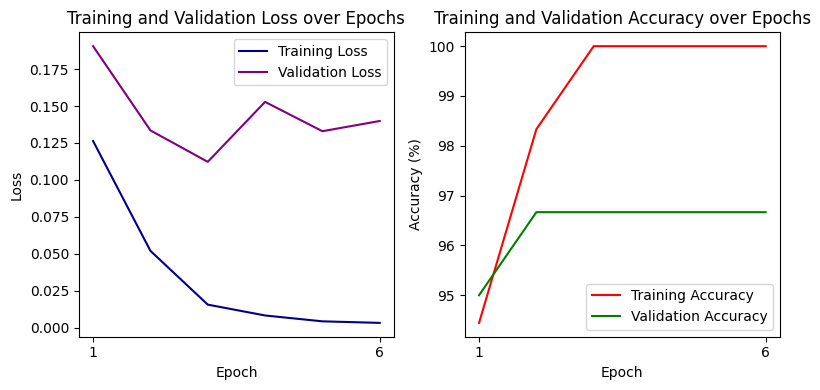

In [134]:
# Gender Prediction using LSTM

# Preprocess data to include train, validation, and test splits
trainloader_lstm_gender_pre, valloader_lstm_gender_pre, testloader_lstm_gender_pre = preprocess_data(X_gender_pre, y_gender_pre, model_type="lstm", task="gender")

# Train and evaluate the model, specifying a model name for saving
train_and_evaluate(trainloader_lstm_gender, valloader_lstm_gender, testloader_lstm_gender, net_lstm_gender, model_name="lstm_gender_pre", num_epochs=50)

Epoch 1/30 Validation Accuracy:
Validation Loss: 0.2840, Validation Accuracy: 95.00%
Epoch 2/30 Validation Accuracy:
Validation Loss: 0.0266, Validation Accuracy: 100.00%
Epoch 3/30 Validation Accuracy:
Validation Loss: 0.0101, Validation Accuracy: 100.00%
Epoch 4/30 Validation Accuracy:
Validation Loss: 0.0061, Validation Accuracy: 100.00%
Epoch 5/30 Validation Accuracy:
Validation Loss: 0.0045, Validation Accuracy: 100.00%
Epoch 6/30 Validation Accuracy:
Validation Loss: 0.0040, Validation Accuracy: 100.00%
Epoch 7/30 Validation Accuracy:
Validation Loss: 0.0035, Validation Accuracy: 100.00%
Epoch 8/30 Validation Accuracy:
Validation Loss: 0.0030, Validation Accuracy: 100.00%
Epoch 9/30 Validation Accuracy:
Validation Loss: 0.0027, Validation Accuracy: 100.00%
Epoch 10/30 Validation Accuracy:
Validation Loss: 0.0026, Validation Accuracy: 100.00%
Epoch 11/30 Validation Accuracy:
Validation Loss: 0.0026, Validation Accuracy: 100.00%
Epoch 12/30 Validation Accuracy:
Validation Loss: 0.0

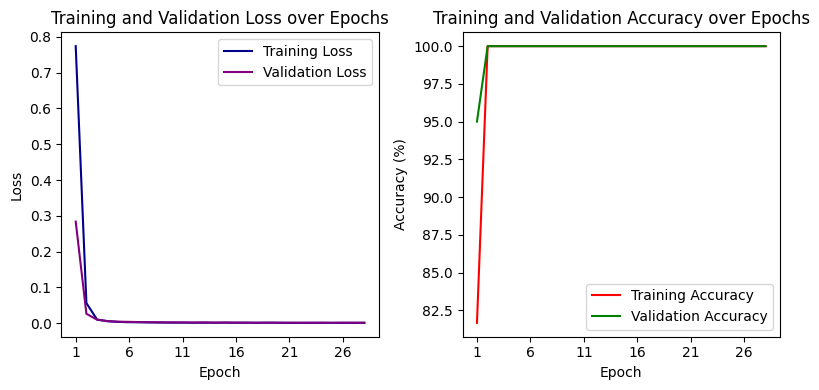

In [135]:
# Gender Prediction using ResNet18

# Preprocess data to include train, validation, and test splits
trainloader_gender_pre, valloader_gender_pre, testloader_gender_pre = preprocess_data(X_gender_pre, y_gender_pre, task="gender")

# Train and evaluate the ResNet18 model for gender prediction
train_and_evaluate(trainloader_gender_pre, valloader_gender_pre, testloader_gender_pre, model_gender, model_name="resnet18_gender_pre", num_epochs=30)

Epoch 1/30 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 2/30 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 3/30 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 4/30 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 5/30 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 6/30 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 7/30 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 8/30 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 9/30 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 10/30 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 11/30 Validation Accuracy:
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 12/30 Validation Accuracy:
Validation Loss: 0.

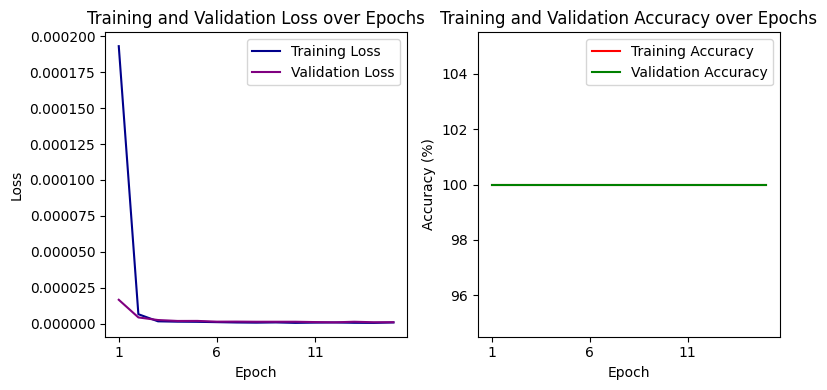

In [136]:
# Gender Prediction using EfficientNet-B0

# Preprocess data to include train, validation, and test splits
trainloader_gender_pre, valloader_gender_pre, testloader_gender_pre = preprocess_data(X_gender_pre, y_gender_pre, task="gender")

# Train and evaluate the EfficientNet-B0 model for gender prediction
train_and_evaluate(trainloader_gender_pre, valloader_gender_pre, testloader_gender_pre, model_gender, model_name="efficientnet_b0_gender_pre", num_epochs=30)

Identity Prediction

Epoch 1/30 Validation Accuracy:
Validation Loss: 3.9153, Validation Accuracy: 2.00%
Epoch 2/30 Validation Accuracy:
Validation Loss: 3.9035, Validation Accuracy: 2.00%
Epoch 3/30 Validation Accuracy:
Validation Loss: 3.9054, Validation Accuracy: 4.00%
Epoch 4/30 Validation Accuracy:
Validation Loss: 3.6554, Validation Accuracy: 8.00%
Epoch 5/30 Validation Accuracy:
Validation Loss: 2.8697, Validation Accuracy: 28.00%
Epoch 6/30 Validation Accuracy:
Validation Loss: 2.3564, Validation Accuracy: 34.00%
Epoch 7/30 Validation Accuracy:
Validation Loss: 2.2270, Validation Accuracy: 38.00%
Epoch 8/30 Validation Accuracy:
Validation Loss: 1.9008, Validation Accuracy: 46.00%
Epoch 9/30 Validation Accuracy:
Validation Loss: 1.9711, Validation Accuracy: 54.00%
Epoch 10/30 Validation Accuracy:
Validation Loss: 1.8510, Validation Accuracy: 50.00%
Epoch 11/30 Validation Accuracy:
Validation Loss: 1.7890, Validation Accuracy: 60.00%
Epoch 12/30 Validation Accuracy:
Validation Loss: 1.7405, Validatio

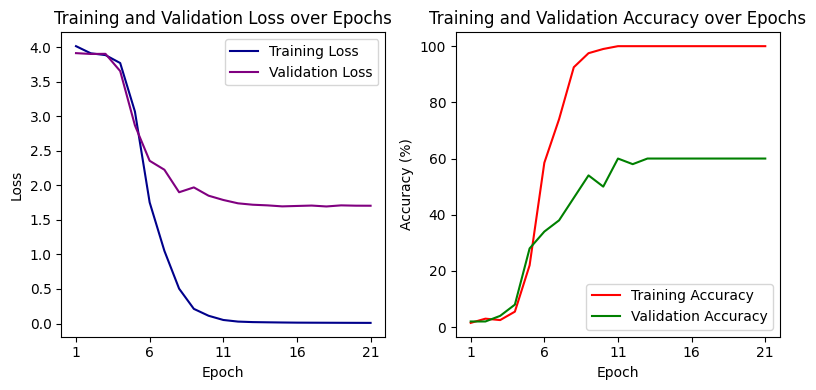

In [137]:
# Identity Prediction using CNN

X_identity_pre, y_identity_pre = prepare_data_identity(folder_path_predefined, ".flac")

# Preprocess data to include train, validation, and test splits
trainloader_identity_pre, valloader_identity_pre, testloader_identity_pre = preprocess_data(X_identity_pre, y_identity_pre, task="identity", num_classes=50)
net_identity = CNN(50)

# Train and evaluate the model, specifying a model name for saving
train_and_evaluate(trainloader_identity_pre, valloader_identity_pre, testloader_identity_pre, net_identity, model_name="cnn_identity_pre", num_epochs=30)

Epoch 1/50 Validation Accuracy:
Validation Loss: 3.8978, Validation Accuracy: 4.00%
Epoch 2/50 Validation Accuracy:
Validation Loss: 3.7015, Validation Accuracy: 4.00%
Epoch 3/50 Validation Accuracy:
Validation Loss: 3.3812, Validation Accuracy: 6.00%
Epoch 4/50 Validation Accuracy:
Validation Loss: 3.2624, Validation Accuracy: 10.00%
Epoch 5/50 Validation Accuracy:
Validation Loss: 3.2637, Validation Accuracy: 6.00%
Epoch 6/50 Validation Accuracy:
Validation Loss: 3.1296, Validation Accuracy: 14.00%
Epoch 7/50 Validation Accuracy:
Validation Loss: 3.0154, Validation Accuracy: 16.00%
Epoch 8/50 Validation Accuracy:
Validation Loss: 2.9415, Validation Accuracy: 22.00%
Epoch 9/50 Validation Accuracy:
Validation Loss: 2.9474, Validation Accuracy: 18.00%
Epoch 10/50 Validation Accuracy:
Validation Loss: 2.9324, Validation Accuracy: 24.00%
Epoch 11/50 Validation Accuracy:
Validation Loss: 2.7544, Validation Accuracy: 28.00%
Epoch 12/50 Validation Accuracy:
Validation Loss: 2.5457, Validatio

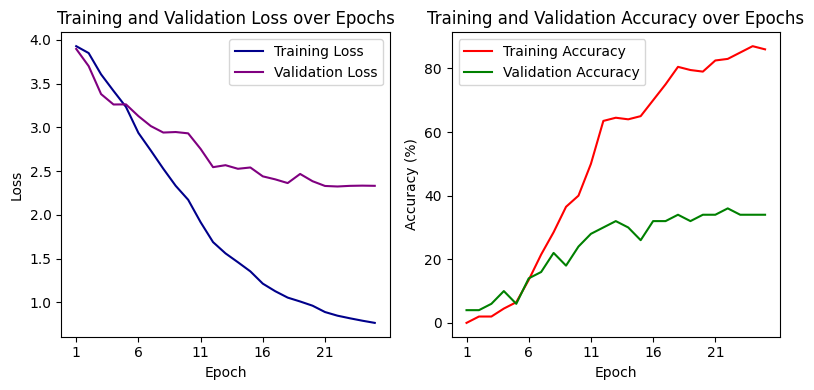

In [138]:
# Identity Prediction using LSTM

# Preprocess data to include train, validation, and test splits
trainloader_identity_pre, valloader_identity_pre, testloader_identity_pre = preprocess_data(X_identity_pre, y_identity_pre, task="identity", model_type="lstm", num_classes=50)

net_lstm_identity = LSTM(input_size=X_identity.shape[2], hidden_size=256, num_layers=2, num_classes=50)

# Train and evaluate the model, specifying a model name for saving
train_and_evaluate(trainloader_identity_pre, valloader_identity_pre, testloader_identity_pre, net_lstm_identity, model_name="lstm_identity_pre", num_epochs=50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 Validation Accuracy:
Validation Loss: 4.4640, Validation Accuracy: 2.00%
Epoch 2/50 Validation Accuracy:
Validation Loss: 2.8540, Validation Accuracy: 30.00%
Epoch 3/50 Validation Accuracy:
Validation Loss: 3.6186, Validation Accuracy: 18.00%
Epoch 4/50 Validation Accuracy:
Validation Loss: 2.3983, Validation Accuracy: 34.00%
Epoch 5/50 Validation Accuracy:
Validation Loss: 2.6734, Validation Accuracy: 32.00%
Epoch 6/50 Validation Accuracy:
Validation Loss: 1.9534, Validation Accuracy: 52.00%
Epoch 7/50 Validation Accuracy:
Validation Loss: 1.6900, Validation Accuracy: 54.00%
Epoch 8/50 Validation Accuracy:
Validation Loss: 1.4889, Validation Accuracy: 56.00%
Epoch 9/50 Validation Accuracy:
Validation Loss: 1.4889, Validation Accuracy: 50.00%
Epoch 10/50 Validation Accuracy:
Validation Loss: 1.7291, Validation Accuracy: 52.00%
Epoch 11/50 Validation Accuracy:
Validation Loss: 1.1604, Validation Accuracy: 64.00%
Epoch 12/50 Validation Accuracy:
Validation Loss: 1.1166, Valida

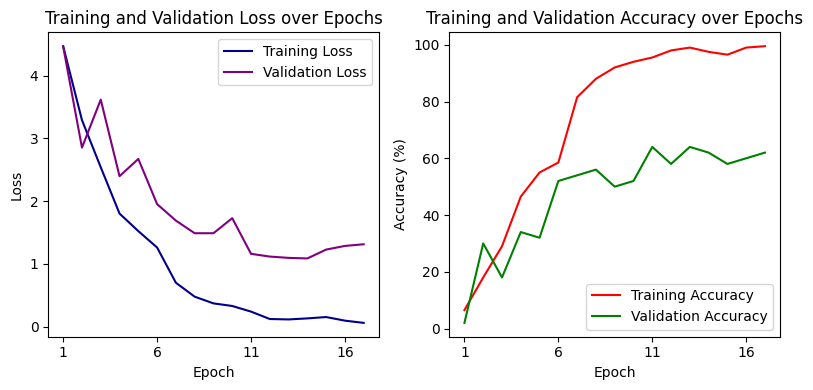

In [139]:
# Identity Prediction using ResNet18

# Preprocess data to include train, validation, and test splits
trainloader_identity_pre, valloader_identity_pre, testloader_identity_pre = preprocess_data(X_identity_pre, y_identity_pre, task="identity")

# Initialize ResNet18 model with the correct number of classes
num_classes_identity = 50
model_identity = modify_resnet18(num_classes_identity)

# Train and evaluate the ResNet18 model for identity prediction
train_and_evaluate(trainloader_identity_pre, valloader_identity_pre, testloader_identity_pre, model_identity, model_name="resnet18_identity", num_epochs=50)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 Validation Accuracy:
Validation Loss: 4.1112, Validation Accuracy: 2.00%
Epoch 2/50 Validation Accuracy:
Validation Loss: 3.8186, Validation Accuracy: 6.00%
Epoch 3/50 Validation Accuracy:
Validation Loss: 2.7816, Validation Accuracy: 26.00%
Epoch 4/50 Validation Accuracy:
Validation Loss: 2.1597, Validation Accuracy: 44.00%
Epoch 5/50 Validation Accuracy:
Validation Loss: 2.1209, Validation Accuracy: 44.00%
Epoch 6/50 Validation Accuracy:
Validation Loss: 1.9119, Validation Accuracy: 54.00%
Epoch 7/50 Validation Accuracy:
Validation Loss: 1.8794, Validation Accuracy: 54.00%
Epoch 8/50 Validation Accuracy:
Validation Loss: 1.5106, Validation Accuracy: 56.00%
Epoch 9/50 Validation Accuracy:
Validation Loss: 1.6339, Validation Accuracy: 54.00%
Epoch 10/50 Validation Accuracy:
Validation Loss: 1.5225, Validation Accuracy: 56.00%
Epoch 11/50 Validation Accuracy:
Validation Loss: 1.4583, Validation Accuracy: 54.00%
Epoch 12/50 Validation Accuracy:
Validation Loss: 1.4014, Validat

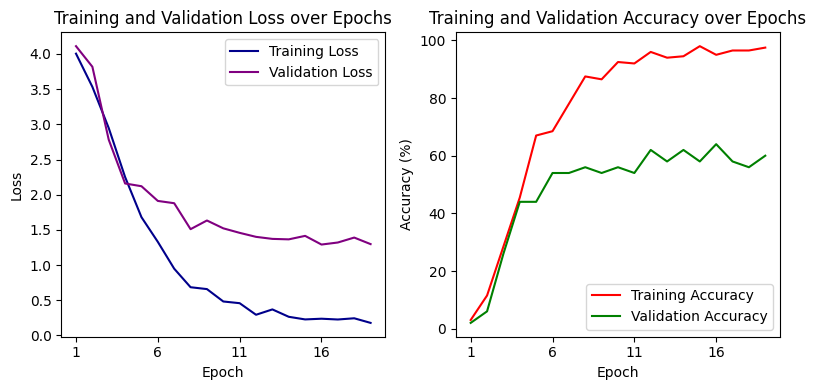

In [140]:
# Identity Prediction using EfficientNet-B0

# Preprocess data to include train, validation, and test splits
trainloader_identity_pre, valloader_identity_pre, testloader_identity_pre = preprocess_data(X_identity_pre, y_identity_pre, task="identity")

# Initialize EfficientNet-B0 model with the correct number of classes
num_classes_identity = 50
model_identity = modify_efficientnet_b0(num_classes_identity)

# Train and evaluate the EfficientNet-B0 model for identity prediction
train_and_evaluate(trainloader_identity_pre, valloader_identity_pre, testloader_identity_pre, model_identity, model_name="efficientnet_b0_identity", num_epochs=50)